# GA Burnt Area Uncertainty Prototype <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with specific `DEA Dev Sandbox` environment
* **Products used:** 
none
* **Special requirements:** GeoTIFFs of input data found within current directory
* **Prerequisites:** To be used in conjunction with other Burnt Area Validation notebooks


## Background

As part of the ARDC Bushfire Data Challenge, this notebook was developed to provide an uncertainty layer that can help inform on the reliability of burn products.

## Description

This notebook searches for GeoTIFFs in a directory, where each GeoTIFF is the output for each burn-area method. The aim is to compare each method to determine a reliability measure on a pixel-by-pixel basis, using the following method:

* The notebook extracts Precision and Recall (PR) values from the GeoTIFFs. 

* PR values are then used to produce an F1-score. 

* F1-scores are combined to give a total F1-score, which then allows a weight to be assigned to the data, based on individual (F1-score) / (total F1-score). 

* A combined layer is created, which shows high reliability when all products agree in their predictions and low reliability where there is high divergence in the predictions, all weighted as above.

* A binary layer is created, which is the best prediction of whether each pixels was burnt or unburnt.

* A model agreement layer is created, which indicates how close the models are in their predictions.

* The combined, binary and model agreement layers are displayed.

***

## Getting started

To run this notebook you need to be in a DEA sandbox environment, with access to burn area results in the form of GeoTIFFs.

## Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [1]:
import glob
import rasterio
import numpy as np
import contextily as cx
import json
import geopandas as gpd

from rasterio import mask
from shapely.geometry import box
from shapely.ops import unary_union
from rasterio.features import geometry_mask
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

## Create a function to load in tif files and accompanying metadata files, returning a dictionary of raster file paths and accompanying accuracy values


In [2]:
def load_tif_files(folder_path):
    tif_files = glob.glob(folder_path + "/*.tif")
    
    #Create an empty list for raster and metadata 
    raster_dict = {}
    
    print("Raster files extracted from {}".format(folder_path))
    print(tif_files)
    for i in tif_files:
        last_slash_index = i.rfind('/')
        meta_fpath = i[:last_slash_index + 1] + 'metadata_' + i[last_slash_index + 1:]
        meta_fpath = meta_fpath.replace(".tif", ".txt")
        
        with open(meta_fpath, 'r') as file:
            for line in file:
                if line.startswith("Precision"):
                    try:
                        precision = float(line.split(":")[1].strip())
                    except IndexError:
                        continue  # Skip this line and move to the next iteration
                elif line.startswith("Recall"):
                    try:
                        recall = float(line.split(":")[1].strip())
                    except IndexError:
                        continue 
                    
        raster_dict[i] = (precision, recall)
    
    return raster_dict

## Load in files from subdirectory "Data_EV"

In [3]:
fpath = "Data_EV/"
rasters = load_tif_files(fpath)
loc_name = "Eastern VIC"

Raster files extracted from Data_EV/
['Data_EV/Eastern_VIC_ga_ls8c_nbart_bc_cyear_3_wofssevere.tif', 'Data_EV/East_Vic_ls_BAC_wo__cy_3_demo.tif', 'Data_EV/East_Vic_ga_ls_rf_cyear_3_demo.tif']


## Create a new dict, rasters_f1, where the dict values are the f1 score

In [4]:
rasters_f1 = {}

for key, value in rasters.items():
    precision, recall = value
    f1_score = 2 * (precision * recall) / (precision + recall)
    rasters_f1[key] = f1_score
    
rasters_f1

{'Data_EV/Eastern_VIC_ga_ls8c_nbart_bc_cyear_3_wofssevere.tif': 83.3693045563549,
 'Data_EV/East_Vic_ls_BAC_wo__cy_3_demo.tif': 70.4876389797253,
 'Data_EV/East_Vic_ga_ls_rf_cyear_3_demo.tif': 84.9626244874048}

## Calculate total f1 score

In [5]:
total_f1 = sum(rasters_f1.values())

print(total_f1)

probability_layer = None

238.81956802348503


## Define the color map

In [6]:
colors = ["gray", "orange"]
orange_cmap = LinearSegmentedColormap.from_list("gray_to_orange", colors)

## Create function to calculate, generate and show preliminary results for the uncertainty layers

In [7]:
def calculate_uncertainty_layers(raster_metric_dict):

    combined_prediction_layer = None
    combined_mask = None

    # Loop through each raster and create weighted layers
    for raster_file, f_score in raster_metric_dict.items():

        # Open the raster file
        with rasterio.open(raster_file) as src:

            source_data = src.read(1)
            print(np.unique(source_data))

            y_resolution = src.transform.e
            if y_resolution > 0:
                # Flip vertically
                source_data = np.flip(source_data, axis=0)

            # Mask out the 0 values in clipped_data
            nan_mask = np.where(source_data == 0, True, False)

            # Calculate the raster data from the masked clipped_data
            raster_data = np.where(np.logical_or(source_data == 1, source_data == 3), 1, 0)
            raster_data = np.ma.array(raster_data, mask=nan_mask)

            # Plot the binary layer
            plt.imshow(raster_data, cmap=orange_cmap)
            plt.title(raster_file)
            plt.show()

            # Calculate the weight for the current raster
            weight = f_score / total_f1

            print(raster_file, " : ", weight)
            print(np.unique(raster_data))
            print("f score : ", f_score)
            print("weight : ", weight)

            # Calculate the weighted layer
            weighted_layer = raster_data * weight

            # Add the weighted layer to the combined_prediction_layer
            if combined_prediction_layer is None:
                combined_prediction_layer = weighted_layer
            else:
                combined_prediction_layer += weighted_layer

            # Add the weighted layer to the combined_prediction_layer
            if combined_mask is None:
                combined_mask = nan_mask
            else:
                combined_mask += nan_mask

            # Create the binary weighted layer
            binary_layer = np.where(combined_prediction_layer < 0.5, 0, 1)
            binary_layer = np.ma.array(binary_layer, mask=combined_mask)

            #Create the model_agreement_layer
            model_agreement_layer = 1 - (abs(combined_prediction_layer - 0.5) * 2)

    return combined_prediction_layer, binary_layer, model_agreement_layer

[0. 1. 2. 3. 4.]


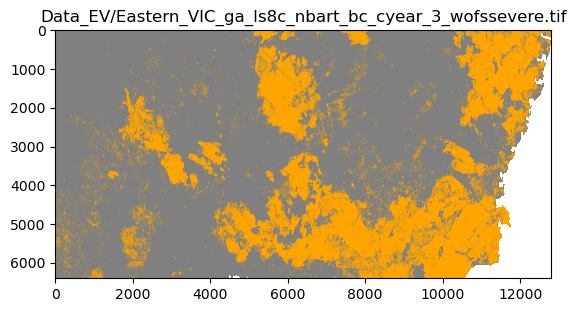

Data_EV/Eastern_VIC_ga_ls8c_nbart_bc_cyear_3_wofssevere.tif  :  0.3490890853137986
[0 1 --]
f score :  83.3693045563549
weight :  0.3490890853137986
[0. 1. 2. 3. 4.]


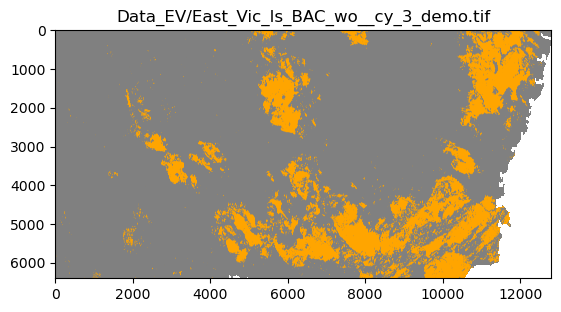

Data_EV/East_Vic_ls_BAC_wo__cy_3_demo.tif  :  0.29515018205205734
[0 1 --]
f score :  70.4876389797253
weight :  0.29515018205205734
[0. 1. 2. 3. 4.]


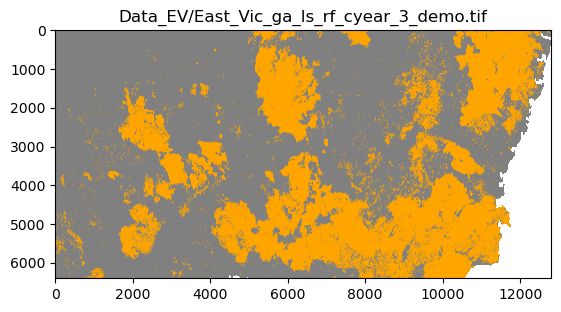

Data_EV/East_Vic_ga_ls_rf_cyear_3_demo.tif  :  0.3557607326341439
[0 1 --]
f score :  84.9626244874048
weight :  0.3557607326341439


In [8]:
combined_prediction_layer, binary_layer, model_agreement_layer = calculate_uncertainty_layers(rasters_f1)

## Plot the probability layer

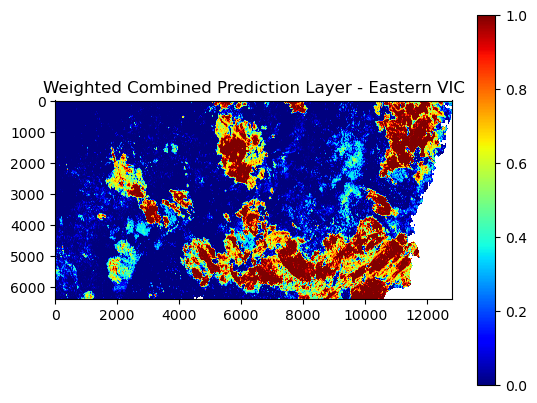

In [9]:
plt.imshow(combined_prediction_layer, cmap='jet')
plt.title('Weighted Combined Prediction Layer - {}'.format(loc_name))
plt.colorbar()
plt.show()

## Plot the binary layer

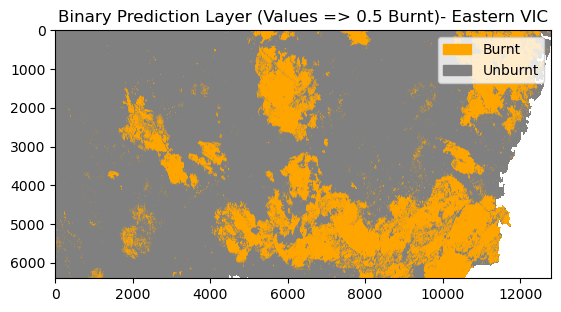

In [10]:
plt.imshow(binary_layer, cmap=orange_cmap)
plt.title('Binary Prediction Layer (Values => 0.5 Burnt)- {}'.format(loc_name))

# Create color patches for the legend
burnt_patch = mpatches.Patch(color='orange', label='Burnt')
unburnt_patch = mpatches.Patch(color='grey', label='Unburnt')
plt.legend(handles=[burnt_patch, unburnt_patch])


plt.show()

## Plot the uncertainty layer

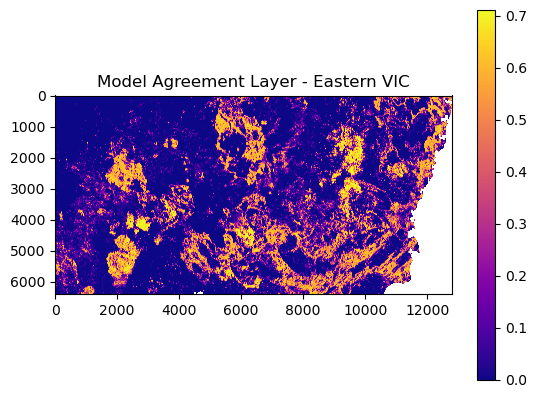

In [11]:
plt.imshow(model_agreement_layer, cmap='plasma')
plt.title('Model Agreement Layer - {}'.format(loc_name))
plt.colorbar()
plt.show()

## Display final outputs

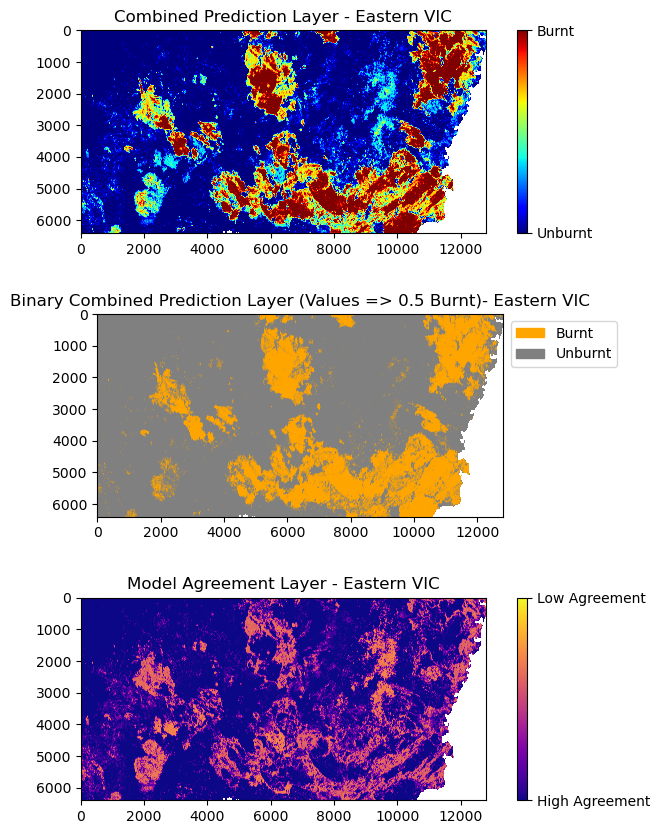

In [12]:
# Create the figure and grid layout
fig = plt.figure(figsize=(8, 10))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])

# Plot the combined prediction layer
ax0 = fig.add_subplot(gs[0])
im0 = ax0.imshow(combined_prediction_layer, cmap='jet')
ax0.set_title('Combined Prediction Layer - {}'.format(loc_name))
cbar0 = fig.colorbar(im0, ax=ax0)
cbar0.set_ticks([0, 1])
cbar0.set_ticklabels(['Unburnt', 'Burnt'])

# Plot the binary layer
ax1 = fig.add_subplot(gs[1])
im1 = ax1.imshow(binary_layer, cmap=orange_cmap)
ax1.set_title('Binary Combined Prediction Layer (Values => 0.5 Burnt)- {}'.format(loc_name))

# Create color patches for the legend
burnt_patch = mpatches.Patch(color='orange', label='Burnt')
unburnt_patch = mpatches.Patch(color='grey', label='Unburnt')

# Plot the model agreement layer
ax2 = fig.add_subplot(gs[2])
im2 = ax2.imshow(model_agreement_layer, cmap='plasma', vmin=0, vmax=1)
ax2.set_title('Model Agreement Layer - {}'.format(loc_name))
cbar2 = fig.colorbar(im2, ax=ax2)
cbar2.set_ticks([0, 1])
cbar2.set_ticklabels(['High Agreement', 'Low Agreement'])

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.4)

# Adjust the legend position
handles = [burnt_patch, unburnt_patch]
leg = ax1.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.3, 1.0))

# Display the plot
plt.show()
